
# Dogecoin (DOGE-USD) — Feature Engineering & Prediction Notebook

This notebook:
1. Loads your `/Dataset/DOGE-USD.csv`
2. Engineers a rich technical feature set
3. Creates targets (next-day log return & direction)
4. Uses a **time-aware split**
5. Trains baseline models:
   - Ridge Regression (returns)
   - Logistic Regression (direction)
   - Gradient Boosting (direction)
6. Evaluates with metrics, ROC curves, and a tiny strategy backtest
7. Saves reusable artifacts (pipelines + engineered features)


In [18]:

# --- Setup
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score, roc_auc_score, roc_curve
)

plt.rcParams["figure.figsize"] = (12, 7)
pd.set_option("display.max_columns", 120)


## 1) Load DOGE-USD data

In [19]:

csv_path = "./../Dataset/DOGE-USD.csv"
df = pd.read_csv(csv_path)

# Normalize headers & parse date
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
date_col_candidates = [c for c in df.columns if c in ["date", "timestamp", "time"]]
if not date_col_candidates:
    raise ValueError("Could not find a date column in DOGE-USD.csv. Expected a 'Date' column.")
date_col = date_col_candidates[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

# Harmonize OHLCV
rename_map = {}
for std, candidates in {
    "open": ["open"],
    "high": ["high"],
    "low": ["low"],
    "close": ["close", "adj_close", "adjclose"],
    "volume": ["volume"]
}.items():
    for c in candidates:
        if c in df.columns:
            rename_map[c] = std
            break
df = df.rename(columns=rename_map)

required_cols = ["open", "high", "low", "close", "volume"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Columns present: {df.columns.tolist()}")

df.head()


,date,open,high,low,close,adj_close,volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


## 2) Feature engineering

In [20]:

feat = df[[date_col, "open", "high", "low", "close", "volume"]].copy()

# Basic returns
feat["log_close"] = np.log(feat["close"].replace(0, np.nan))
feat["ret_1d"] = feat["close"].pct_change()
feat["log_ret_1d"] = feat["log_close"].diff()

# Lags of returns
for lag in [1, 2, 3, 5, 10]:
    feat[f"log_ret_lag_{lag}"] = feat["log_ret_1d"].shift(lag)

# MAs & stddevs
for w in [5, 10, 21, 50, 100]:
    feat[f"sma_{w}"] = feat["close"].rolling(w).mean()
for w in [5, 21]:
    feat[f"rstd_{w}"] = feat["close"].rolling(w).std()

# Bollinger width (20)
mid = feat["close"].rolling(20).mean()
std = feat["close"].rolling(20).std()
upper = mid + 2*std
lower = mid - 2*std
feat["bb_width"] = (upper - lower) / (mid + 1e-12)

# EMAs / MACD
feat["ema_12"] = feat["close"].ewm(span=12, adjust=False).mean()
feat["ema_26"] = feat["close"].ewm(span=26, adjust=False).mean()
feat["macd"] = feat["ema_12"] - feat["ema_26"]
feat["macd_signal"] = feat["macd"].ewm(span=9, adjust=False).mean()
feat["macd_hist"] = feat["macd"] - feat["macd_signal"]

# RSI (14)
delta = feat["close"].diff()
gain = np.where(delta > 0, delta, 0.0)
loss = np.where(delta < 0, -delta, 0.0)
roll_up = pd.Series(gain, index=feat.index).rolling(14).mean()
roll_down = pd.Series(loss, index=feat.index).rolling(14).mean()
rs = roll_up / (roll_down + 1e-12)
feat["rsi_14"] = 100 - (100 / (1 + rs))

# Stoch %K/%D
low14 = feat["low"].rolling(14).min()
high14 = feat["high"].rolling(14).max()
feat["stoch_k"] = 100 * (feat["close"] - low14) / (high14 - low14 + 1e-12)
feat["stoch_d"] = feat["stoch_k"].rolling(3).mean()

# ATR (14)
tr1 = feat["high"] - feat["low"]
tr2 = (feat["high"] - feat["close"].shift(1)).abs()
tr3 = (feat["low"] - feat["close"].shift(1)).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
feat["atr_14"] = tr.rolling(14).mean()

# OBV + zscore
obv = [0]
for i in range(1, len(feat)):
    if feat.loc[i, "close"] > feat.loc[i-1, "close"]:
        obv.append(obv[-1] + feat.loc[i, "volume"])
    elif feat.loc[i, "close"] < feat.loc[i-1, "close"]:
        obv.append(obv[-1] - feat.loc[i, "volume"])
    else:
        obv.append(obv[-1])
feat["obv"] = obv
feat["obv_z"] = (feat["obv"] - pd.Series(obv).rolling(20).mean()) / (pd.Series(obv).rolling(20).std() + 1e-12)

# Volume zscore
feat["vol_z20"] = (feat["volume"] - feat["volume"].rolling(20).mean()) / (feat["volume"].rolling(20).std() + 1e-12)

# Price structure
feat["high_low_spread"] = (feat["high"] - feat["low"]) / (feat["close"] + 1e-12)
feat["close_open_ratio"] = (feat["close"] - feat["open"]) / (feat["open"] + 1e-12)

# Calendar
feat["dow"] = feat[date_col].dt.dayofweek
feat = pd.concat([feat, pd.get_dummies(feat["dow"], prefix="dow", drop_first=True)], axis=1)

# Targets
feat["y_logret_next"] = feat["log_ret_1d"].shift(-1)
feat["y_up_next"] = (feat["y_logret_next"] > 0).astype(int)

feat = feat.dropna().reset_index(drop=True)
feat.head()


/var/folders/dr/4hb3w_yn2xq77d2njhl6shph0000gn/T/ipykernel_6711/1409053268.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feat["ret_1d"] = feat["close"].pct_change()


,date,open,high,low,close,volume,log_close,ret_1d,log_ret_1d,log_ret_lag_1,log_ret_lag_2,log_ret_lag_3,log_ret_lag_5,log_ret_lag_10,sma_5,sma_10,sma_21,sma_50,sma_100,rstd_5,rstd_21,bb_width,ema_12,ema_26,macd,macd_signal,macd_hist,rsi_14,stoch_k,stoch_d,atr_14,obv,obv_z,vol_z20,high_low_spread,close_open_ratio,dow,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,y_logret_next,y_up_next
0,2018-02-16,0.007295,0.007485,0.006529,0.007034,26553900.0,-4.957000,-0.042602,-0.043537,0.087717,0.177046,0.029885,-0.006637,0.210554,0.006444,0.005603,0.005563,0.008123,0.005787,0.000843,0.001187,0.833695,0.005944,0.006232,-0.000288,-0.000713,0.000425,69.203062,81.392508,89.221278,0.000908,1.430552e+09,1.229492,0.864607,0.135911,-0.035778,4,False,False,False,True,False,False,0.002130,1
1,2018-02-17,0.007064,0.007322,0.006853,0.007049,18333100.0,-4.954870,0.002132,0.002130,-0.043537,0.087717,0.177046,0.099045,-0.014784,0.006760,0.005878,0.005548,0.008076,0.005843,0.000664,0.001164,0.811209,0.006114,0.006292,-0.000178,-0.000606,0.000428,65.737185,81.697883,83.618350,0.000846,1.448885e+09,1.751213,-0.020716,0.066534,-0.002123,5,False,False,False,False,True,False,-0.092845,0
2,2018-02-18,0.007114,0.007144,0.006330,0.006424,15291500.0,-5.047714,-0.088665,-0.092845,0.002130,-0.043537,0.087717,0.029885,0.060720,0.006917,0.006064,0.005498,0.008047,0.005896,0.000351,0.001098,0.790949,0.006162,0.006302,-0.000140,-0.000513,0.000373,67.310651,68.973941,77.354777,0.000822,1.433594e+09,1.326354,-0.355470,0.126712,-0.096992,6,False,False,False,False,False,True,0.041619,1
3,2018-02-19,0.006410,0.006938,0.006341,0.006697,13019200.0,-5.006096,0.042497,0.041619,-0.092845,0.002130,-0.043537,0.177046,0.090800,0.006910,0.006234,0.005485,0.008001,0.005951,0.000356,0.001082,0.808000,0.006244,0.006331,-0.000087,-0.000428,0.000340,80.098934,74.531759,75.067861,0.000787,1.446613e+09,1.580413,-0.577615,0.089144,0.044774,0,False,False,False,False,False,False,0.057590,1
4,2018-02-20,0.006679,0.008288,0.006399,0.007094,107911000.0,-4.948506,0.059280,0.057590,0.041619,-0.092845,0.002130,0.087717,-0.002202,0.006860,0.006444,0.005536,0.007965,0.006011,0.000290,0.001132,0.839139,0.006375,0.006388,-0.000013,-0.000345,0.000332,78.321243,72.576941,72.027547,0.000823,1.554524e+09,3.034750,3.839900,0.266281,0.062135,1,True,False,False,False,False,False,-0.075063,0


In [21]:

engineered_path = "./../Dataset/doge_engineered_features.csv"
feat.to_csv(engineered_path, index=False)
engineered_path


'./../Dataset/doge_engineered_features.csv'

## 3) Time-aware split

In [22]:

n = len(feat)
split_idx = int(n * 0.8)
train_df = feat.iloc[:split_idx].copy()
test_df = feat.iloc[split_idx:].copy()

exclude_cols = {date_col, "y_logret_next", "y_up_next"}
X_cols = [c for c in feat.columns if c not in exclude_cols]

X_train = train_df[X_cols].copy()
y_train_reg = train_df["y_logret_next"].copy()
y_train_cls = train_df["y_up_next"].copy()

X_test = test_df[X_cols].copy()
y_test_reg = test_df["y_logret_next"].copy()
y_test_cls = test_df["y_up_next"].copy()

len(train_df), len(test_df)


(1327, 332)

## 4) Pipelines & baseline models

In [23]:

numeric_features = X_cols
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer([("num", numeric_transformer, numeric_features)], remainder="drop")

ridge = Pipeline([("prep", preprocess),
                  ("model", RidgeCV(alphas=np.logspace(-4, 4, 21)))])
logreg = Pipeline([("prep", preprocess),
                   ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))])
gb_clf = Pipeline([("prep", preprocess),
                   ("model", GradientBoostingClassifier())])

ridge.fit(X_train, y_train_reg)
logreg.fit(X_train, y_train_cls)
gb_clf.fit(X_train, y_train_cls)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['open', 'high', 'low',
                                                   'close', 'volume',
                                                   'log_close', 'ret_1d',
                                                   'log_ret_1d',
                                                   'log_ret_lag_1',
                                                   'log_ret_lag_2',
                                                   'log_ret_lag_3',
                                                   'log_ret_lag_5',
                                                   'log_ret_lag_10', 'sma_5',
                                                   'sma_10', 'sma_21', 'sma_50',
                                                   'sma_100', 'rstd_5',
                                                   'rstd_21', 'bb_width',
                                                   'ema_12', 'ema_26', 'macd',
                                                   'macd_signal', 'macd_hist',
                                                   'rsi_14', 'stoch_k',
                                                   'stoch_d', 'atr_14', ...])])),
                ('model', GradientBoostingClassifier())])

## 5) Evaluation (metrics + curves)

In [24]:

# Regression
ridge_pred = ridge.predict(X_test)
ridge_mae = mean_absolute_error(y_test_reg, ridge_pred)
ridge_r2 = r2_score(y_test_reg, ridge_pred)
ridge_dir_acc = accuracy_score(y_test_cls, (ridge_pred > 0).astype(int))

# Classification
logreg_proba = logreg.predict_proba(X_test)[:, 1]
gb_proba = gb_clf.predict_proba(X_test)[:, 1]

logreg_pred = (logreg_proba >= 0.5).astype(int)
gb_pred = (gb_proba >= 0.5).astype(int)

logreg_acc = accuracy_score(y_test_cls, logreg_pred)
gb_acc = accuracy_score(y_test_cls, gb_pred)

logreg_auc = roc_auc_score(y_test_cls, logreg_proba)
gb_auc = roc_auc_score(y_test_cls, gb_proba)

summary = pd.DataFrame({
    "Metric": [
        "Ridge MAE (logret)", "Ridge R2", "Ridge Direction Acc",
        "LogReg Acc", "LogReg AUC",
        "GB Acc", "GB AUC"
    ],
    "Value": [ridge_mae, ridge_r2, ridge_dir_acc, logreg_acc, logreg_auc, gb_acc, gb_auc]
})
summary


,Metric,Value
0,Ridge MAE (logret),0.035253
1,Ridge R2,-0.022636
2,Ridge Direction Acc,0.484940
3,LogReg Acc,0.533133
4,LogReg AUC,0.573892
5,GB Acc,0.500000
6,GB AUC,0.534850


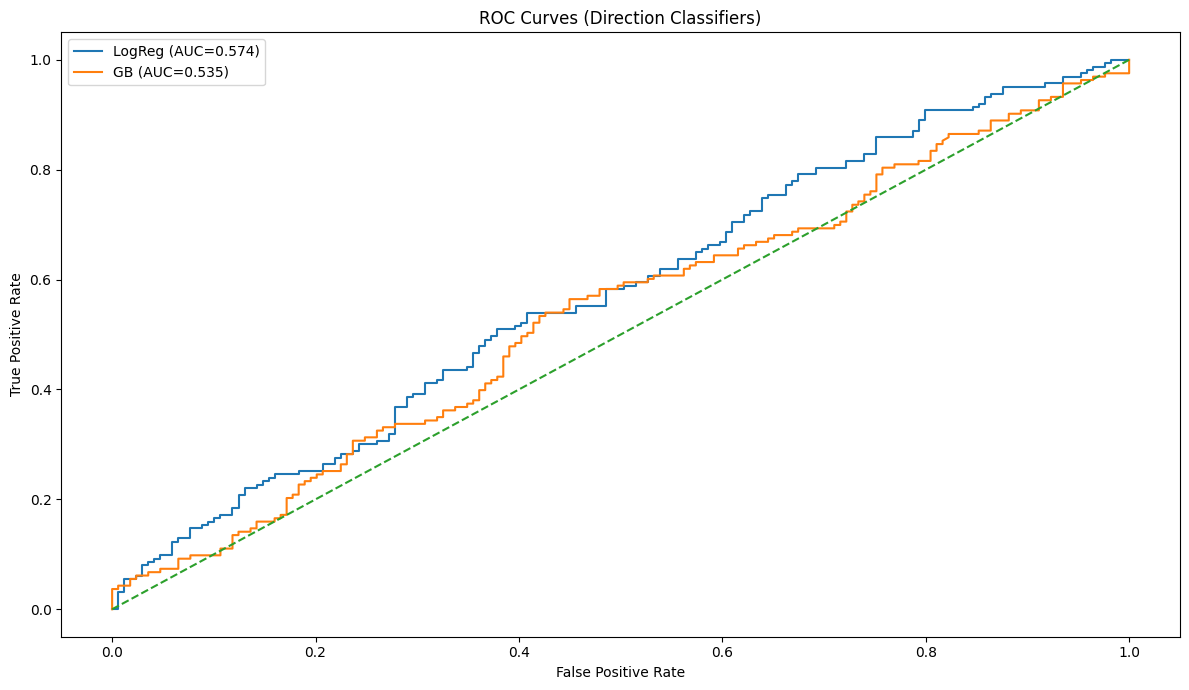

In [25]:

fpr_logreg, tpr_logreg, _ = roc_curve(y_test_cls, logreg_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test_cls, gb_proba)

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f"LogReg (AUC={logreg_auc:.3f})")
plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC={gb_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curves (Direction Classifiers)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


## 6) Tiny strategy backtest

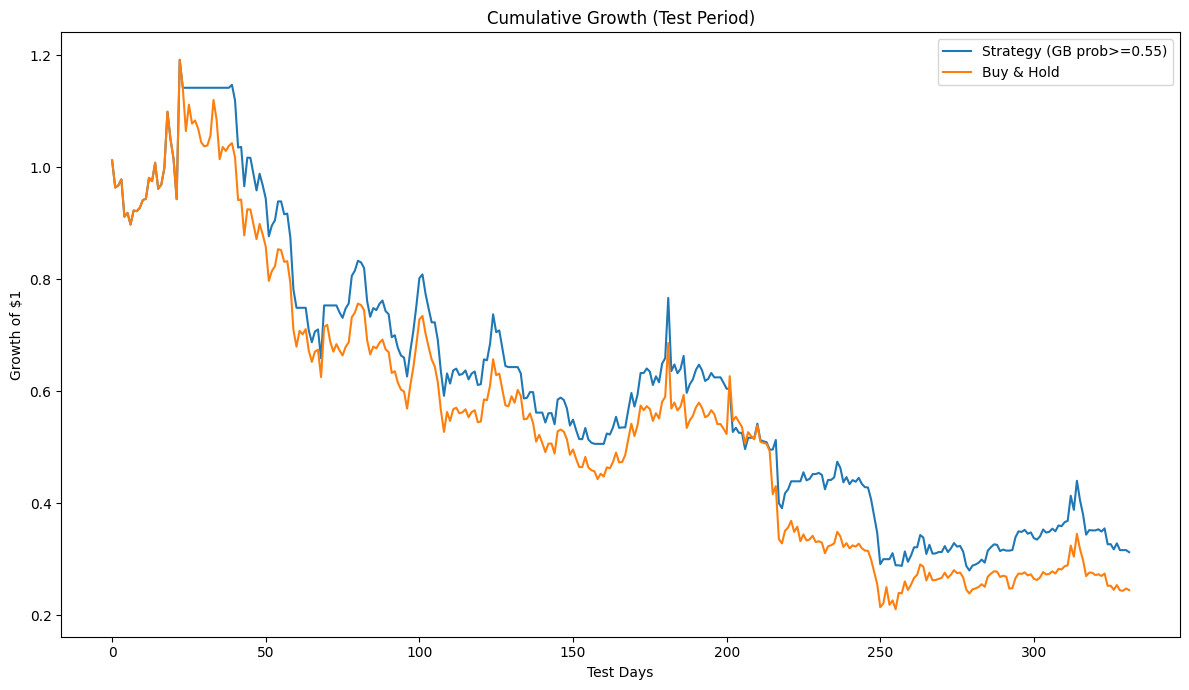

In [26]:

prob_up = gb_proba
signal = (prob_up >= 0.55).astype(int)

strategy_logret = signal * y_test_reg.values
bh_logret = y_test_reg.values

strategy_cum = np.exp(np.cumsum(strategy_logret))
bh_cum = np.exp(np.cumsum(bh_logret))

plt.figure()
plt.plot(range(len(strategy_cum)), strategy_cum, label="Strategy (GB prob>=0.55)")
plt.plot(range(len(bh_cum)), bh_cum, label="Buy & Hold")
plt.title("Cumulative Growth (Test Period)")
plt.xlabel("Test Days")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Save artifacts

In [27]:

import json

joblib.dump(ridge, "./../Dataset/ridge_pipeline.pkl")
joblib.dump(logreg, "./../Dataset/logreg_pipeline.pkl")
joblib.dump(gb_clf, "./../Dataset/gb_clf_pipeline.pkl")

with open("./../Dataset/feature_columns.txt", "w") as f:
    for c in X_cols:
        f.write(c + "\n")

print("Saved:")
print("- ./../Dataset/ridge_pipeline.pkl")
print("- ./../Dataset/logreg_pipeline.pkl")
print("- ./../Dataset/gb_clf_pipeline.pkl")
print("- ./../Dataset/doge_engineered_features.csv")
print("- ./../Dataset/feature_columns.txt")


Saved:
- ./../Dataset/ridge_pipeline.pkl
- ./../Dataset/logreg_pipeline.pkl
- ./../Dataset/gb_clf_pipeline.pkl
- ./../Dataset/doge_engineered_features.csv
- ./../Dataset/feature_columns.txt



## 8) Next steps (ideas)
- Add multi-horizon targets (t+3, t+5) and tune thresholds with **walk-forward CV**.
- Add regime features (HV, ADX), breakout indicators, and candle-shape stats.
- Incorporate exogenous signals (BTC/ETH returns, DXY, on-chain, funding rates).
- Try tree ensembles with randomized hyperparameter search; consider LightGBM/XGBoost where available.
- Upgrade to sequence models (TCN/LSTM/Transformer) with strict time-based CV and leakage guards.
